In [1]:
import os

import typing
import time
from dataclasses import dataclass, field

import numpy as np
from scipy.ndimage import gaussian_filter
import cv2 as cv
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



def Img_Downsampler(ImagePath):
    """Previously used it to decrease computation cost. But it is not needed."""
    image = Image.open(ImagePath)
    image = np.array(image)
    image = np.expand_dims(image, axis=2)

    
    rows = image.shape[0]
    cols = image.shape[1]

    logic_indices = np.zeros_like(image, dtype=np.bool)

    if rows > cols:
        row_indices = np.around(np.linspace(0, rows - 1, num=240)).astype(
            np.int
        )
        col_indices = row_indices[row_indices < cols]
    else:
        col_indices = np.around(np.linspace(0, cols - 1, num=240)).astype(
            np.int
        )

        row_indices = col_indices[col_indices < rows]

    logic_rows = np.zeros_like(image, dtype=np.bool)
    logic_rows[row_indices, :, :] = True
    logic_cols = np.zeros_like(image, dtype=np.bool)
    logic_cols[:, col_indices, :] = True

    logic_indices = np.logical_and(logic_rows, logic_cols)

    downsampled_image = image[logic_indices].reshape(
        len(row_indices), len(col_indices), 1
    )

    return downsampled_image

In [2]:

class CrfParameters:
    """Parameters for 8-neighbourhood CRF with Gaussian kernels."""

    # Weights for each kernel.
    kernel_weights: typing.List = field(default_factory=lambda: [10, 5])
    # Spatial standard deviation for appearance kernel.
    theta_alpha: float = 60
    # Color standard deviation for appearance kernel.
    theta_beta: float = 10
    # Spatial standard deviation for smoothness kernel.
    theta_gamma: float = 1
    # Whether to use naive or efficient message passing. Couldn't implement efficient message passing :/
    efficient_message_passing: bool = False

    # Number of iterations to perform.
    iterations: int = 4


def appearance_kernel(x_1,y_1,p_1,x_2,y_2,p_2,theta_alpha,theta_beta):
    """Compute appearance kernel.
    -------
    Args:
        x_1: X coordinate of first pixel.
        y_1: Y coordinate of first pixel.
        p_1: Color vector of first pixel.
        x_2: X coordinate of second pixel.
        y_2: Y coordinate of second pixel.
        p_2: Color vector of second pixel.
        theta_alpha: Standard deviation for the position.
        theta_beta: Standard deviation for the color.
    -------
    Returns:
        The output of the appearence kernel.
    """
    return np.exp(
        -((x_1 - x_2) ** 2.0 + (y_1 - y_2) ** 2.0) / (2 * theta_alpha ** 2.0)
        - np.sum((p_1 - p_2) ** 2.0) / (2.0 * theta_beta ** 2.0)
    )


def smoothness_kernel(x_1,y_1,p_1,x_2,y_2,p_2,theta_gamma):
    """Compute smoothness kernel.
    -------
    Args:
        x_1: X coordinate of first pixel.
        y_1: Y coordinate of first pixel.
        p_1: Color vector of first pixel.
        x_2: X coordinate of second pixel.
        y_2: Y coordinate of second pixel.
        p_2: Color vector of second pixel.
        theta_gamma: Standard deviation for the position.
    -------
    Returns:
        The output of the smoothness kernel.
    """
    del p_1, p_2
    return np.exp(
        -((x_1 - x_2) ** 2.0 + (y_1 - y_2) ** 2.0) / (2.0 * theta_gamma ** 2.0)
    )


def normalize(potentials):
    """Normalize potentials such that output is a valid pixelwise distribution.
    -------
    Args:
        potentials: Array of potentials. Shape (H,W,N).
    -------
    Returns:
        Probability array with same shape as potentials.
        Probabilities sum up to 1 at every slice (i,j,:).
    """
    Normalized_Potentials=np.zeros(potentials.shape)
    for i in range(potentials.shape[0]):
        for j in range(potentials.shape[1]):
            SliceSum=sum(potentials[i,j,:])
            Normalized_Potentials[i,j,:]=potentials[i,j,:]/SliceSum
            
    return Normalized_Potentials

                                
def message_passing(image,current_probabilities,kernel_functions) :
    """Perform "message passing" as the first step of the inference loop.
    -------
    Args:
        image:
            Array of size ROWS x COLUMNS x CHANNELS, representing the image used to
            compute the kernel.
        current_probabilities:
            Array of size ROWS x COLUMNS x CLASSES, representing the current
            probabilities.
        kernel_functions: The kernel functions defining the edge potential.
    -------
    Returns:
        Array of size ROWS x COLUMNS x CLASSES x KERNELS, representing the intermediate
        result of message passing for each kernel.
    """
    # naive version
    rows = image.shape[0]
    cols = image.shape[1]
    classes = current_probabilities.shape[2]
    result = np.zeros(
        (
            current_probabilities.shape[0],
            current_probabilities.shape[1],
            current_probabilities.shape[2],
            len(kernel_functions),
        ),
        dtype=float,
    )
    
    for kernel in range(len(kernel_functions)):
        for row in range(1,rows-1):
            for col in range(1,cols-1):
                for classe in range(classes):                        
                        Krnel1=kernel_functions[kernel](row,col,image[row,col,:],row-1,col,image[row-1,col,:])
                        Krnel2=kernel_functions[kernel](row,col,image[row,col,:],row,col-1,image[row,col-1,:])
                        Krnel3=kernel_functions[kernel](row,col,image[row,col,:],row,col+1,image[row,col+1,:])
                        Krnel4=kernel_functions[kernel](row,col,image[row,col,:],row+1,col,image[row+1,col,:])
                        Krnel5=kernel_functions[kernel](row,col,image[row,col,:],row-1,col-1,image[row-1,col-1,:])
                        Krnel6=kernel_functions[kernel](row,col,image[row,col,:],row-1,col+1,image[row-1,col+1,:])
                        Krnel7=kernel_functions[kernel](row,col,image[row,col,:],row+1,col-1,image[row+1,col-1,:])
                        Krnel8=kernel_functions[kernel](row,col,image[row,col,:],row+1,col+1,image[row+1,col+1,:])
                        
                        
                        Result1=Krnel1*current_probabilities[row-1,col,classe]
                        Result2=Krnel2*current_probabilities[row,col-1,classe]
                        Result3=Krnel3*current_probabilities[row,col+1,classe]
                        Result4=Krnel4*current_probabilities[row+1,col,classe]
                        Result5=Krnel5*current_probabilities[row-1,col-1,classe]
                        Result6=Krnel6*current_probabilities[row-1,col+1,classe]
                        Result7=Krnel7*current_probabilities[row+1,col-1,classe]
                        Result8=Krnel8*current_probabilities[row+1,col+1,classe]
                        
                        result[row,col,classe,kernel]=Result1+Result2+Result3+Result4+Result5+Result6+Result7+Result8

    return result

    
    
    
def compatibility_Transform(q_tilde, weights):
    """Perform compatability transform as part of the inference loop.
    -------
    Args:
        q_tilde:
            Array of size ROWS x COLUMNS x CLASSES x KERNELS, representing the
            intermediate result of message passing for each kernel.
        weights: Weights of each kernel.
    -------
    Returns:
        Array of size ROWS x COLUMNS x CLASSES, representing the result after combining
        the kernels and applying the label compatability function (here: Potts model).
    """
    Updated_Probabilities=np.zeros(
        (
            q_tilde.shape[0],
            q_tilde.shape[1],
            q_tilde.shape[2],
        ),
        dtype=float,
    )
    for classe2 in range(q_tilde.shape[2]):  
        for row in range(q_tilde.shape[0]):
             for col in range(q_tilde.shape[1]):
                for classe in range(q_tilde.shape[2]):            
                    for i in range(q_tilde.shape[3]):   
                        if q_tilde[row,col,classe,i] == q_tilde[row,col,classe2,i]:
                            continue 
                        Updated_Probabilities[row,col,classe2]+=weights[i]*q_tilde[row,col,classe,i]                    
                     
    return Updated_Probabilities                      

def local_Update(q_hat, unary_potential):
    """Perform local update as part of the interefence loop.
    -------
    Args:
        q_hat:
            Array of size ROWS x COLUMNS x CLASSES, representing the intermediate result
            after combining the kernels and applying the label compatability function.
        unary_potential:
            Array of size ROWS x COLUMNS x CLASSES, representing the prior energy for
            each pixel and class from a different source.
    -------
    Returns:
        Array of size ROWS x COLUMNS x CLASSES, representing the probabilities for each
        pixel and class.
    """
    # TODO: implement local update
    Updated_q_hat=np.zeros(
        (
            q_hat.shape[0],
            q_hat.shape[1],
            q_hat.shape[2],
        ),
        dtype=float,
    )
    
    Updated_q_hat=np.exp(-unary_potential-q_hat)
    
    return Updated_q_hat

def inference(image, initial_probabilities, params):
    """Perform inference in 8-neighbourhood CRF with Gaussian edge potentials.
    -------
    Args:
        image:
            Array of size ROWS x COLUMNS x CHANNELS, representing the image used the
            features.
        initial_probabilities:
            Initial pixelwise probabilities for each class. Used to initialize unary
            potential.
        params:
            Parameter class for 8-neighbourhood CRF.
    -------
    Return:
        Array of size ROWS x COLS x CLASSES
    """
    
    # define kernels
    kernels = [
        lambda x1, y1, p1, x2, y2, p2: appearance_kernel(
            x1, y1, p1, x2, y2, p2, params.theta_alpha, params.theta_beta
        ),
        lambda x1, y1, p1, x2, y2, p2: smoothness_kernel(
            x1, y1, p1, x2, y2, p2, params.theta_gamma
        ),
    ]
    # initialize
    current_probabilities = initial_probabilities

    unary_potential = -np.log(current_probabilities)

    for _ in np.arange(params.iterations):
        q_tilde = message_passing(image, current_probabilities, kernels)
            
        q_hat = compatibility_Transform(q_tilde, params.kernel_weights)
        unnormalized_probabilities = local_Update(q_hat, unary_potential)
        current_probabilities = normalize(unnormalized_probabilities)

    return current_probabilities


def load_Segmentation(segmentation_path, unknown = None):
    """Load a segmentation at a given path as a numpy array.
    -------
    Args:
        segmentation_path: Path of the segmentation.
        unknown:
            Color of unlabeled, will be assigned index 0, if none, index 0 still
            correponds to unknown.
    -------        
    Returns:
        Array containing the segmentation. Shape (H,W).
    """
    seg_rgb = Img_Downsampler(segmentation_path)
    rows = seg_rgb.shape[0]  
    cols = seg_rgb.shape[1]  
    seg_colors = seg_rgb.reshape(
        -1, seg_rgb.shape[2]
    )  

    colors = np.unique(seg_colors, axis=0)
    seg = np.empty(
        seg_colors.shape[0], dtype=np.uint8
    )  

    # swap unknown color s.t. it is at index 0
    if unknown is not None:
        if unknown.tolist() in colors.tolist():
            index = np.argmax(np.all(unknown == colors, 1))
            colors[[0, index]] = colors[[index, 0]]
        else:
            colors = np.vstack((unknown.reshape((1, -1)), colors))
            print("no unknown")

    for color_id, color in enumerate(colors):
        if unknown is None:
            seg[np.all(seg_colors == color, 1)] = color_id + 1
        else:
            seg[np.all(seg_colors == color, 1)] = color_id

    return seg.reshape(rows, cols)


def plot_Segmentation(segmentation,image, initialSegmentation,saveas = None,):
    """Plot a segmentation.
    -------
    Args:
        segmentation:
            Either 2D array of integers representing the class or 3D array, with last
            dimension being the probabilities of each class.
            Shape (H,W) or (H,W,N), respectively.
        image: Show this image as input.
        initialSegmentation: GroundTruth segmentation image.
        saveas: The path to save the image to.
    """
    figure = plt.figure()
    plt.axis("off")


    # plot image&reference with result
    fig, axes = plt.subplots(1,3, figsize=(11,5))
    axes[0].set_title("Original Image")
    axes[0].imshow(image, cmap='gray')
    axes[0].axis("off")
    axes[1].set_title("CRF Output")
    if segmentation.ndim == 2:
        axes[1].imshow(segmentation,cmap='gray')
        axes[1].axis("off")
    elif segmentation.ndim == 3:
        axes[1].imshow(np.argmax(segmentation, axis=2) + 1,cmap='gray')
        axes[1].axis("off")
    axes[2].set_title("GroundTruth")
    axes[2].imshow(initialSegmentation, cmap='gray')
    axes[2].axis("off")

    if saveas is not None:
            plt.savefig(saveas, bbox_inches="tight", pad_inches=0.0)

    figure.show()



In [3]:
def segmentation_to_probabilities(segmentation, prior_probability= 0.7):
    """Convert a segmentation into unary probabilities.
    -------
    Converts a pixelwise segmentation into probabilities for each class. The
    prior_probability defines the probabiltiy of the specified class. The remaining
    probability mass is uniformly distributed across the remaining classes.
    -------
    Args:
        segmentation:
            2D integer array, representing the class per pixel. 0 indicates unknown.
        prior_probability: Probability assigned to the specified class.
    """
    classes = np.amax(segmentation)
    rows = segmentation.shape[0]
    cols = segmentation.shape[1]
    segm = segmentation.reshape(-1)
    probabilities = np.zeros((segm.shape[0], classes), dtype=np.float)

    for class_id in np.arange(start=0, stop=classes + 1):
        # unknown -> uniform probabilities
        if class_id == 0:
            probabilities[segm == class_id, :] = 1.0 / classes
        else:
            probabilities[segm == class_id, class_id - 1] = prior_probability
            probabilities[segm == class_id, 0 : class_id - 1] = (
                1 - prior_probability
            ) / (classes - 1)
            probabilities[segm == class_id, class_id:] = (1 - prior_probability) / (
                classes - 1
            )
    return probabilities.reshape((rows, cols, classes))


def Initalize(image_path, segmentation_path, output_path = None):
    """Run the refine mode.
    -------
    Takes an image and an initilal segmentation to produce a refined segmentation.
    -------
    Args:
        image_path: Path of the image.
        segmentation_path: Path of the initial segmentation.
        output_path: Path to save the refined segmentation to.
    """
    image = Img_Downsampler(image_path)
    initial_segmentation = load_Segmentation(
        segmentation_path, unknown=None)


    initial_probabilities = segmentation_to_probabilities(initial_segmentation, 0.7)

    params = CrfParameters()

    # low res message passing
    params.kernel_weights = [
        10,
        1,
    ]  
    final_probabilities = inference(image, initial_probabilities, params)
    plot_Segmentation(final_probabilities,image,initial_segmentation,'CRF_OUTPUT_plane_193th_Subject88')
    initial_segmentation_1d=initial_segmentation.flatten()
    final_segmentation_1d=(np.argmax(final_probabilities, axis=2) + 1).flatten()
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(initial_segmentation_1d,final_segmentation_1d)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(initial_segmentation_1d,final_segmentation_1d)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(initial_segmentation_1d,final_segmentation_1d)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(initial_segmentation_1d,final_segmentation_1d)
    print('F1 score: %f' % f1)
    

    
 

Accuracy: 0.996128
Precision: 0.998343
Recall: 0.997728
F1 score: 0.998035


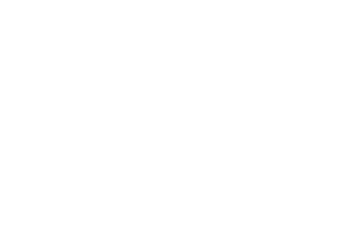

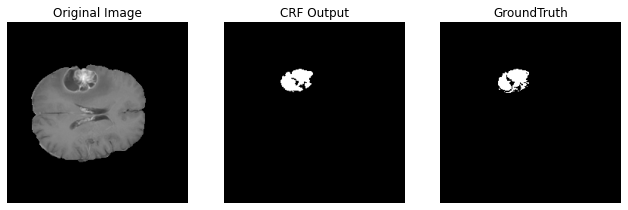

In [4]:
ImagePath='C:\\Users\\ataka\\Desktop\\CS554 Final Project\\plane_193th_Subject88.png'
SegmentationPath='C:\\Users\\ataka\\Desktop\\CS554 Final Project\\Labels_plane_193th_Subject88.png'
OutputPath='C:\\Users\\ataka\\Desktop\\CS554 Final Project'
Initalize(ImagePath, SegmentationPath, OutputPath)